In [270]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib as plt
from obspy import read, read_inventory
from obspy.core import UTCDateTime
from obspy.core.stream import Stream

In [244]:
min_filtering_frequency = 0.1
max_filtering_frequency = 30

root_folder = "data"
ud01_data_folder_path = root_folder+"/UD01"
ud02_data_folder_path = root_folder+"/UD02"
ud03_data_folder_path = root_folder+"/UD03"
ud04_data_folder_path = root_folder+"/UD04"

directions_data_folders = ["6d97e2", "6d97n2"]

In [245]:
def process_station_data(station_data_folder):
    import os 
    station_data = Stream()
    for direction in directions_data_folders:
        direction_stream = Stream()
        data_folder = station_data_folder+"/"+direction
        for filename in os.listdir(data_folder):
            direction_stream+=read(data_folder+"/"+filename)
        direction_stream.merge()
        station_data+=direction_stream
    return station_data

In [246]:
first_station_data = process_station_data(ud01_data_folder_path)
# first_station_data += process_station_data(ud02_data_folder_path)
# first_station_data += process_station_data(ud03_data_folder_path)
# first_station_data += process_station_data(ud04_data_folder_path)


1. слепить всё в кучу
2. получим объект Stream, его len будет равен количеству трасс
3. находим максимальное количество элементов в трассе
4. запускаем цикл от 0 до этого количества
5. каждому времени в tr.times() соответствует один элемент в tr.data
6. создаём list в котором будут tuple's вида ( <время>, <количество трасс> )
7. перебираем tr.data[i], если там не None (скорее всего будет None, если данных нет, нужно проверить), то увеличиваем счётчик 
    количества трасс
8. перебрав все трассы сохраняем в list нужный tuple. 
9. берём следующий индекс

In [19]:
class CustomStream(Stream):
    def __init__(self, stream):
        self.traces_stats = list()
        self.stream = stream

In [56]:
max = 0
for i in range(len(first_station_data)):
    trace = first_station_data[i]
    length = len(trace)
    if length > max:
        max = length
print(max)

360000


In [ ]:
stats_list = list()
times = first_station_data[0].times()
number_of_traces = len(first_station_data)
for time in times:
    number_of_active_traces = 0
    index = np.where(times==time)[0][0]
    for i in range(number_of_traces):
        trace = first_station_data[i]
        if trace.data[index] != None:
            number_of_active_traces+=1
    stats_list.append((time, number_of_active_traces))

1. вырезать куски данных, где происходили события. например, из суток возникает 3 файла. это будет триггер. 
2. матрица данных, вектор времён, какая трасса какой компоненте и какой станции соответствует, массив количества живых трасс - сделать свой класс. 

1. эти триггеры отдавать Елизавете
2. (Л)подобрать параметры для автоматического триггирования
3. далее пытаемся применить машинное обучение с полученным параметром триггирования

1. считываю все данные
2. все data из каждой трассы сохранить в матрицу
3. получится огромная матрица данных
4. None заменять нулями
5. добавить временной ряд
6. добавить количество живых трасс
7. в объекте так же сохраняем время начало отсчёта, время конца отсчёта

1. (Л) выяснить название триггер-файла
2. (Л) выяснить длину промежутка

1. UDINA_год_месяц_день_час_минута_секунда

In [171]:
def trace_preprocessing(data):
    station_data = data.copy()
    trace1 = s
#     for i in range(len(station_data)):

    
#     print(station_data)
#     for (i, trace) in enumerate(station_data):
#         print('i = {0}'.format(i))
#         copied_trace = trace.copy()
#         if hasattr(copied_trace, 'data'):
#             print('copied_trace = {0}'.format(copied_trace))
#             if hasattr(copied_trace.data, 'mask'):
#                 print('remove bad data')
#                 indexes = np.where(copied_trace.data.mask == True)
#                 print('indexes = {0}'.format(indexes))
#                 copied_trace.data.data[indexes] = 0
#                 trace.data = copied_trace.data.data
#                 station_data[i].data = trace.data
    return station_data
        

In [247]:
normalized_station_data = trace_preprocessing(first_station_data)

2 Trace(s) in Stream:
.6D97..HHE | 2018-05-05T10:00:00.000000Z - 2018-05-05T15:59:59.990000Z | 100.0 Hz, 2160000 samples (masked)
.6D97..HHN | 2018-05-05T11:00:00.000000Z - 2018-05-05T15:59:59.990000Z | 100.0 Hz, 1800000 samples (masked)
i = 0
copied_trace = .6D97..HHE | 2018-05-05T10:00:00.000000Z - 2018-05-05T15:59:59.990000Z | 100.0 Hz, 2160000 samples (masked)
remove bad data
indexes = (array([ 360000,  360001,  360002, ..., 1799997, 1799998, 1799999],
      dtype=int64),)
i = 1
copied_trace = .6D97..HHN | 2018-05-05T11:00:00.000000Z - 2018-05-05T15:59:59.990000Z | 100.0 Hz, 1800000 samples (masked)
remove bad data
indexes = (array([ 360000,  360001,  360002, ..., 1439997, 1439998, 1439999],
      dtype=int64),)


In [248]:
data_array = []
for trace in normalized_station_data.traces:
    data_array.append(trace.data)

In [249]:
data_array

[array([23772, 23788, 23702, ...,  9274,  9315,  9333]),
 array([-19754, -20921, -20072, ...,  -2650,  -2578,  -2649])]

In [250]:
length = len(data_array[0])
times = normalized_station_data[0].times('utcdatetime')

In [251]:
len(times)

2160000

In [258]:
trace_stats = list()
for i in range(length):
    trace_count = 0
    for j in range(2):
        trace = data_array[j]
        #print('trace[i] = {0}'.format(trace[i]))
        if trace[i] != 0:
            trace_count+=1
    
    trace_stats.append((times[i], trace_count))
    

IndexError: index 1800000 is out of bounds for axis 0 with size 1800000

In [256]:
trace_stats

[(2018-05-05T10:00:00.000000Z, 2)]

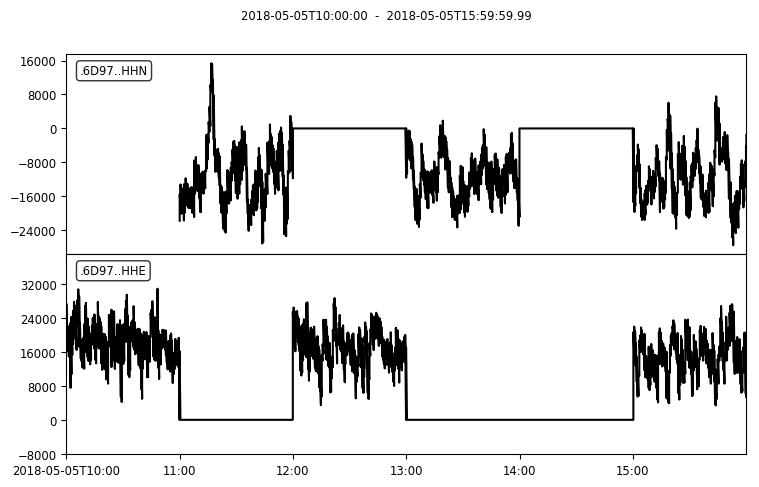

In [252]:
normalized_station_data.plot()

In [260]:
trace1 = first_station_data[0]
trace2 = first_station_data[1]
times1 = trace1.times('utcdatetime')
times2 = trace2.times('utcdatetime')
print(len(times1))
print(len(times2))

2160000
1800000


In [308]:
type(times1)

numpy.ma.core.MaskedArray

In [264]:
delta = np.delete(times1, times2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  """Entry point for launching an IPython kernel.


TypeError: int() argument must be a string, a bytes-like object or a number, not 'UTCDateTime'

In [265]:
times1_data = times1.data
times2_data = 

In [277]:
delta = len(times1_data) - len(times2_data)

In [299]:
list1 = times1.data[0:delta]
list2 = times2.data
print(list1)
print(list2)

[UTCDateTime(2018, 5, 5, 10, 0) UTCDateTime(2018, 5, 5, 10, 0, 0, 10000)
 UTCDateTime(2018, 5, 5, 10, 0, 0, 20000) ...
 UTCDateTime(2018, 5, 5, 10, 59, 59, 970000)
 UTCDateTime(2018, 5, 5, 10, 59, 59, 980000)
 UTCDateTime(2018, 5, 5, 10, 59, 59, 990000)]
[UTCDateTime(2018, 5, 5, 11, 0) UTCDateTime(2018, 5, 5, 11, 0, 0, 10000)
 UTCDateTime(2018, 5, 5, 11, 0, 0, 20000) ...
 UTCDateTime(2018, 5, 5, 15, 59, 59, 970000)
 UTCDateTime(2018, 5, 5, 15, 59, 59, 980000)
 UTCDateTime(2018, 5, 5, 15, 59, 59, 990000)]


In [301]:
data = np.concatenate([list1, list2])
len(data)
print(data)

[UTCDateTime(2018, 5, 5, 10, 0) UTCDateTime(2018, 5, 5, 10, 0, 0, 10000)
 UTCDateTime(2018, 5, 5, 10, 0, 0, 20000) ...
 UTCDateTime(2018, 5, 5, 15, 59, 59, 970000)
 UTCDateTime(2018, 5, 5, 15, 59, 59, 980000)
 UTCDateTime(2018, 5, 5, 15, 59, 59, 990000)]


In [303]:
new_times = ma.masked_array(data, mask=np.concatenate([times1.mask[:delta],times2.mask]))

In [304]:
new_times

masked_array(data=[UTCDateTime(2018, 5, 5, 10, 0),
                   UTCDateTime(2018, 5, 5, 10, 0, 0, 10000),
                   UTCDateTime(2018, 5, 5, 10, 0, 0, 20000), ...,
                   UTCDateTime(2018, 5, 5, 15, 59, 59, 970000),
                   UTCDateTime(2018, 5, 5, 15, 59, 59, 980000),
                   UTCDateTime(2018, 5, 5, 15, 59, 59, 990000)],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
            dtype=object)

In [306]:
normalized_station_data[0].times = new_times

In [310]:
normalized_station_data[0].times()

TypeError: 'MaskedArray' object is not callable

In [311]:
trace1 = first_station_data[0]

In [312]:
trace1

.6D97..HHE | 2018-05-05T10:00:00.000000Z - 2018-05-05T15:59:59.990000Z | 100.0 Hz, 2160000 samples (masked)

In [313]:
trace1.stats

         network: 
         station: 6D97
        location: 
         channel: HHE
       starttime: 2018-05-05T10:00:00.000000Z
         endtime: 2018-05-05T15:59:59.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 2160000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 129, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 4096, 'filesize': 528384})

In [314]:
trace2.stats

         network: 
         station: 6D97
        location: 
         channel: HHN
       starttime: 2018-05-05T11:00:00.000000Z
         endtime: 2018-05-05T15:59:59.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 1800000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 134, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 4096, 'filesize': 548864})

In [322]:
trace2.stats

         network: 
         station: 6D97
        location: 
         channel: HHN
       starttime: 2018-05-05T10:00:00.000000Z
         endtime: 2018-05-05T15:59:59.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 2160000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 134, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 4096, 'filesize': 548864})

In [319]:
new_times[len(new_times)-1]

2018-05-05T15:59:59.990000Z

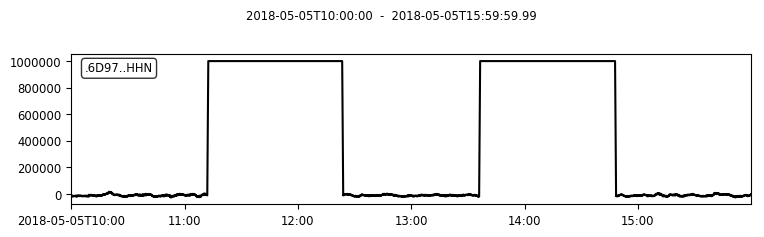

In [323]:
trace2.plot()

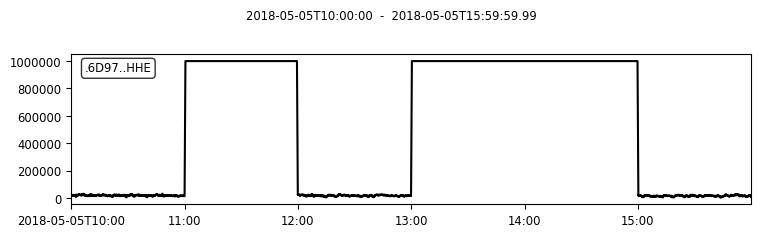

In [324]:
trace1.plot()